# WRF Downloader Notebook

### Imports

In [28]:
import xarray as xr
import rioxarray
import pandas as pd
import geopandas as gpd
import numpy as np
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import os
import xcdat as xc
from metpy.calc import relative_humidity_from_specific_humidity
from metpy.units import units
from datetime import datetime as dt

### Download files from S3

Open Dataset on AWS S3 `s3://wrf-cmip6-noversioning/downscaled_products/gcm`. 

From there, lots of different runs, bias corrected runs suffixed `_bc`. 

Can see directory to browse here: https://wrf-cmip6-noversioning.s3.amazonaws.com/index.html#downscaled_products/gcm/

In [29]:
from concurrent.futures import ThreadPoolExecutor

BUCKET_NAME = 'wrf-cmip6-noversioning'
OUTPUT_DIR = 'data/'
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED, max_pool_connections=24))

def generateFileNames(start_date: str, end_date: str, model: str, data_tier: int, domain: int, historical: bool, bias_correction: bool) -> list[str]:
    r = pd.date_range(start_date, end_date, freq='1h', inclusive='left', normalize=True)
    file_prefix = {1: "wrfout", 2: "auxhist"}
    path = f'downscaled_products/gcm/{model}{"_historical" if historical else ""}{"_bc" if bias_correction else ""}/hourly'
    # Gross check since files start sept 1 in each yearly directory
    return ["%s/%s/d0%s/%s_d01_%s" % (path, d.year if d.month > 9 else d.year - 1, domain, file_prefix[data_tier], pd.to_datetime(d).strftime('%Y-%m-%d_%H:%M:%S')) for d in r]

def downloadS3File(bucket: str, file: str, output_dir: str) -> str:
    if output_dir[-1] == '/':
        output_dir = output_dir[:-1]
    output_file = "%s/%s_%s.nc" % (output_dir, file.split('/')[2], file.split('/')[-1].replace(':', '-'))
    s3.download_file(bucket, file, output_file)
    return output_file

def downloadMetadataFile(domain: int, output_dir: str = OUTPUT_DIR, coord: bool = False) -> str:
    if output_dir[-1] == '/':
        output_dir = output_dir[:-1]
    file_name = f'wrfinput_d0{domain}{"_coord.nc" if coord else ""}'
    s3_path = "downscaled_products/wrf_coordinates/%s" % (file_name)
    output_file = "%s/%s" % (output_dir, file_name)
    s3.download_file(BUCKET_NAME, s3_path, output_file)
    return output_file

def getLatLonHgtFromMetadata(metadata_file: str) -> (xr.DataArray, xr.DataArray, xr.DataArray):
    data = xr.open_dataset(metadata_file)
    lat = data.variables["XLAT"]
    lon = data.variables["XLONG"]
    hgt = data.variables["HGT"]
    
    lon_wrf = lon[0,:,:]
    lat_wrf = lat[0,:,:]
    hgt_wrf = hgt[0,:,:]
    lat_wrf = xr.DataArray(lat_wrf, dims=["y", "x"])
    lon_wrf = xr.DataArray(lon_wrf, dims=["y", "x"])
    hgt_wrf = xr.DataArray(hgt_wrf, dims=["y", "x"])

    return (lat_wrf, lon_wrf, hgt_wrf)
    

In [32]:
files = generateFileNames('2020-01-01', '2020-01-08', 'cesm2_r11i1p1f1_ssp245', 2, 2, False, False)

start_time = dt.now()
with ThreadPoolExecutor(24) as executor:
    downloaded_files = executor.map(lambda file: downloadS3File(BUCKET_NAME, file, OUTPUT_DIR), files)

end_time = dt.now()

print('Time to download {} files: {} seconds'.format(len(list(downloaded_files)), (end_time - start_time).seconds))

Time to download 168 files: 25 seconds


In [33]:
x = xr.open_mfdataset("data/[!wrfinput]*", combine='nested', concat_dim='Time')
x

<xarray.Dataset> Size: 1GB
Dimensions:  (Time: 168, south_north: 340, west_east: 270)
Dimensions without coordinates: Time, south_north, west_east
Data variables: (12/22)
    Times    (Time) |S19 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    Q2       (Time, south_north, west_east) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    T2       (Time, south_north, west_east) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    PSFC     (Time, south_north, west_east) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    U10      (Time, south_north, west_east) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    V10      (Time, south_north, west_east) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    ...       ...
    LWUPB    (Time, south_north, west_east) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    LWUPBC   (Time, south_north, west_east) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    LWDNB    (Time, south_north, west_east) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    LWDNBC   (Time, south_north, west_east) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    RUNSF    (Time, south_north, west_east) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    RUNSB    (Time, south_north, west_east) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
Attributes: (12/85)
    TITLE:                            OUTPUT FROM WRF V4.1.3 MODEL
    START_DATE:                      2019-12-19_00:00:00
    WEST-EAST_GRID_DIMENSION:        271
    SOUTH-NORTH_GRID_DIMENSION:      341
    BOTTOM-TOP_GRID_DIMENSION:       40
    DX:                              9000.0
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      0
    ETAC:                            0.0

In [36]:
md = downloadMetadataFile(2)

lat, lon, hgt = getLatLonHgtFromMetadata(md)

In [37]:
x = x.assign_coords(lat=lat, lon=lon).assign(hgt=hgt).rename({'south_north': 'y', 'west_east': 'x'})

In [38]:
byte_times = x['Times']
time_strs = [str(time.values)[1:].replace("_", " ") for time in byte_times]
dts = pd.to_datetime(time_strs).strftime('%Y-%m-%dT%H:%M')
x = x.rename({'Time': 'time'}).assign(time=dts).drop_vars('Times')
x

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 168, y: 340, x: 270)
Coordinates:
    lat      (y, x) float32 367kB ...
    lon      (y, x) float32 367kB ...
  * time     (time) object 1kB '2020-01-01T00:00' ... '2020-01-07T23:00'
Dimensions without coordinates: y, x
Data variables: (12/22)
    Q2       (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    T2       (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    PSFC     (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    U10      (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    V10      (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    SNOW     (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    ...       ...
    LWUPBC   (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    LWDNB    (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    LWDNBC   (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    RUNSF    (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    RUNSB    (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    hgt      (y, x) float32 367kB ...
Attributes: (12/85)
    TITLE:                            OUTPUT FROM WRF V4.1.3 MODEL
    START_DATE:                      2019-12-19_00:00:00
    WEST-EAST_GRID_DIMENSION:        271
    SOUTH-NORTH_GRID_DIMENSION:      341
    BOTTOM-TOP_GRID_DIMENSION:       40
    DX:                              9000.0
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      0
    ETAC:                            0.0

### Clip to Polygon, Calculate Windspeed and Relative Humidity and Total Precip

In [47]:
# Calculate Relative Humidity using Specific Humidity, Temperature, and Pressure 
# See https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.relative_humidity_from_specific_humidity.html
# x = x.assign(RH=relative_humidity_from_specific_humidity(x.PSFC * units.Pa, x.T2 * units.degK , x.Q2))
# Calculate Windspeed (directionless) using U and V Components
# x = x.assign(WS10=np.sqrt(x.U10**2 + x.V10**2))
# x = x.assign(TP=x.RAINC + x.RAINNC)

# Keep Just the Vars we want
# x = x[['T2', 'RAINC', 'RAINNC', 'U10', 'V10', 'LWDNB', 'SWDNB', 'Q2', 'PSFC']]

In [63]:
x

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 168, y: 340, x: 270)
Coordinates:
    lat      (y, x) float32 367kB ...
    lon      (y, x) float32 367kB ...
  * time     (time) object 1kB '2020-01-01T00:00' ... '2020-01-07T23:00'
Dimensions without coordinates: y, x
Data variables: (12/21)
    Q2       (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    T2       (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    PSFC     (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    U10      (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    V10      (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    SNOW     (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    ...       ...
    LWUPB    (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    LWUPBC   (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    LWDNB    (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    LWDNBC   (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    RUNSF    (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    RUNSB    (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
Attributes: (12/85)
    TITLE:                            OUTPUT FROM WRF V4.1.3 MODEL
    START_DATE:                      2019-12-19_00:00:00
    WEST-EAST_GRID_DIMENSION:        271
    SOUTH-NORTH_GRID_DIMENSION:      341
    BOTTOM-TOP_GRID_DIMENSION:       40
    DX:                              9000.0
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      0
    ETAC:                            0.0

In [64]:
from shapely import vectorized
cen_lat = x.CEN_LAT
cen_lon = x.CEN_LON
sp1 = x.TRUELAT1
sp2 = x.TRUELAT2

mask = gpd.read_file('skagit_bound_poly.json')

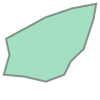

In [65]:
mask.geometry.item()

In [66]:
skagit_mask = vectorized.contains(mask.geometry.item(), x.lon.values, x.lat.values)
skagit_mask
# Bias towards indluding touching bounsing boxes

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [67]:
masked_data_set = x.where(skagit_mask)
masked_data_set

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 168, y: 340, x: 270)
Coordinates:
    lat      (y, x) float32 367kB 22.27 22.31 22.35 22.4 ... 57.5 57.54 57.58
    lon      (y, x) float32 367kB -116.7 -116.6 -116.6 ... -111.2 -111.0 -110.9
  * time     (time) object 1kB '2020-01-01T00:00' ... '2020-01-07T23:00'
Dimensions without coordinates: y, x
Data variables: (12/21)
    Q2       (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    T2       (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    PSFC     (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    U10      (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    V10      (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    SNOW     (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    ...       ...
    LWUPB    (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    LWUPBC   (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    LWDNB    (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    LWDNBC   (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    RUNSF    (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    RUNSB    (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
Attributes: (12/85)
    TITLE:                            OUTPUT FROM WRF V4.1.3 MODEL
    START_DATE:                      2019-12-19_00:00:00
    WEST-EAST_GRID_DIMENSION:        271
    SOUTH-NORTH_GRID_DIMENSION:      341
    BOTTOM-TOP_GRID_DIMENSION:       40
    DX:                              9000.0
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      0
    ETAC:                            0.0

2024-09-13 13:38:53,259 [WARNING]: animation.py(save:1057) >> MovieWriter ffmpeg unavailable; using Pillow instead.
2024-09-13 13:38:53,259 [WARNING]: animation.py(save:1057) >> MovieWriter ffmpeg unavailable; using Pillow instead.
2024-09-13 13:38:53,260 [INFO]: animation.py(save:1060) >> Animation.save using <class 'matplotlib.animation.PillowWriter'>
2024-09-13 13:38:53,260 [INFO]: animation.py(save:1060) >> Animation.save using <class 'matplotlib.animation.PillowWriter'>


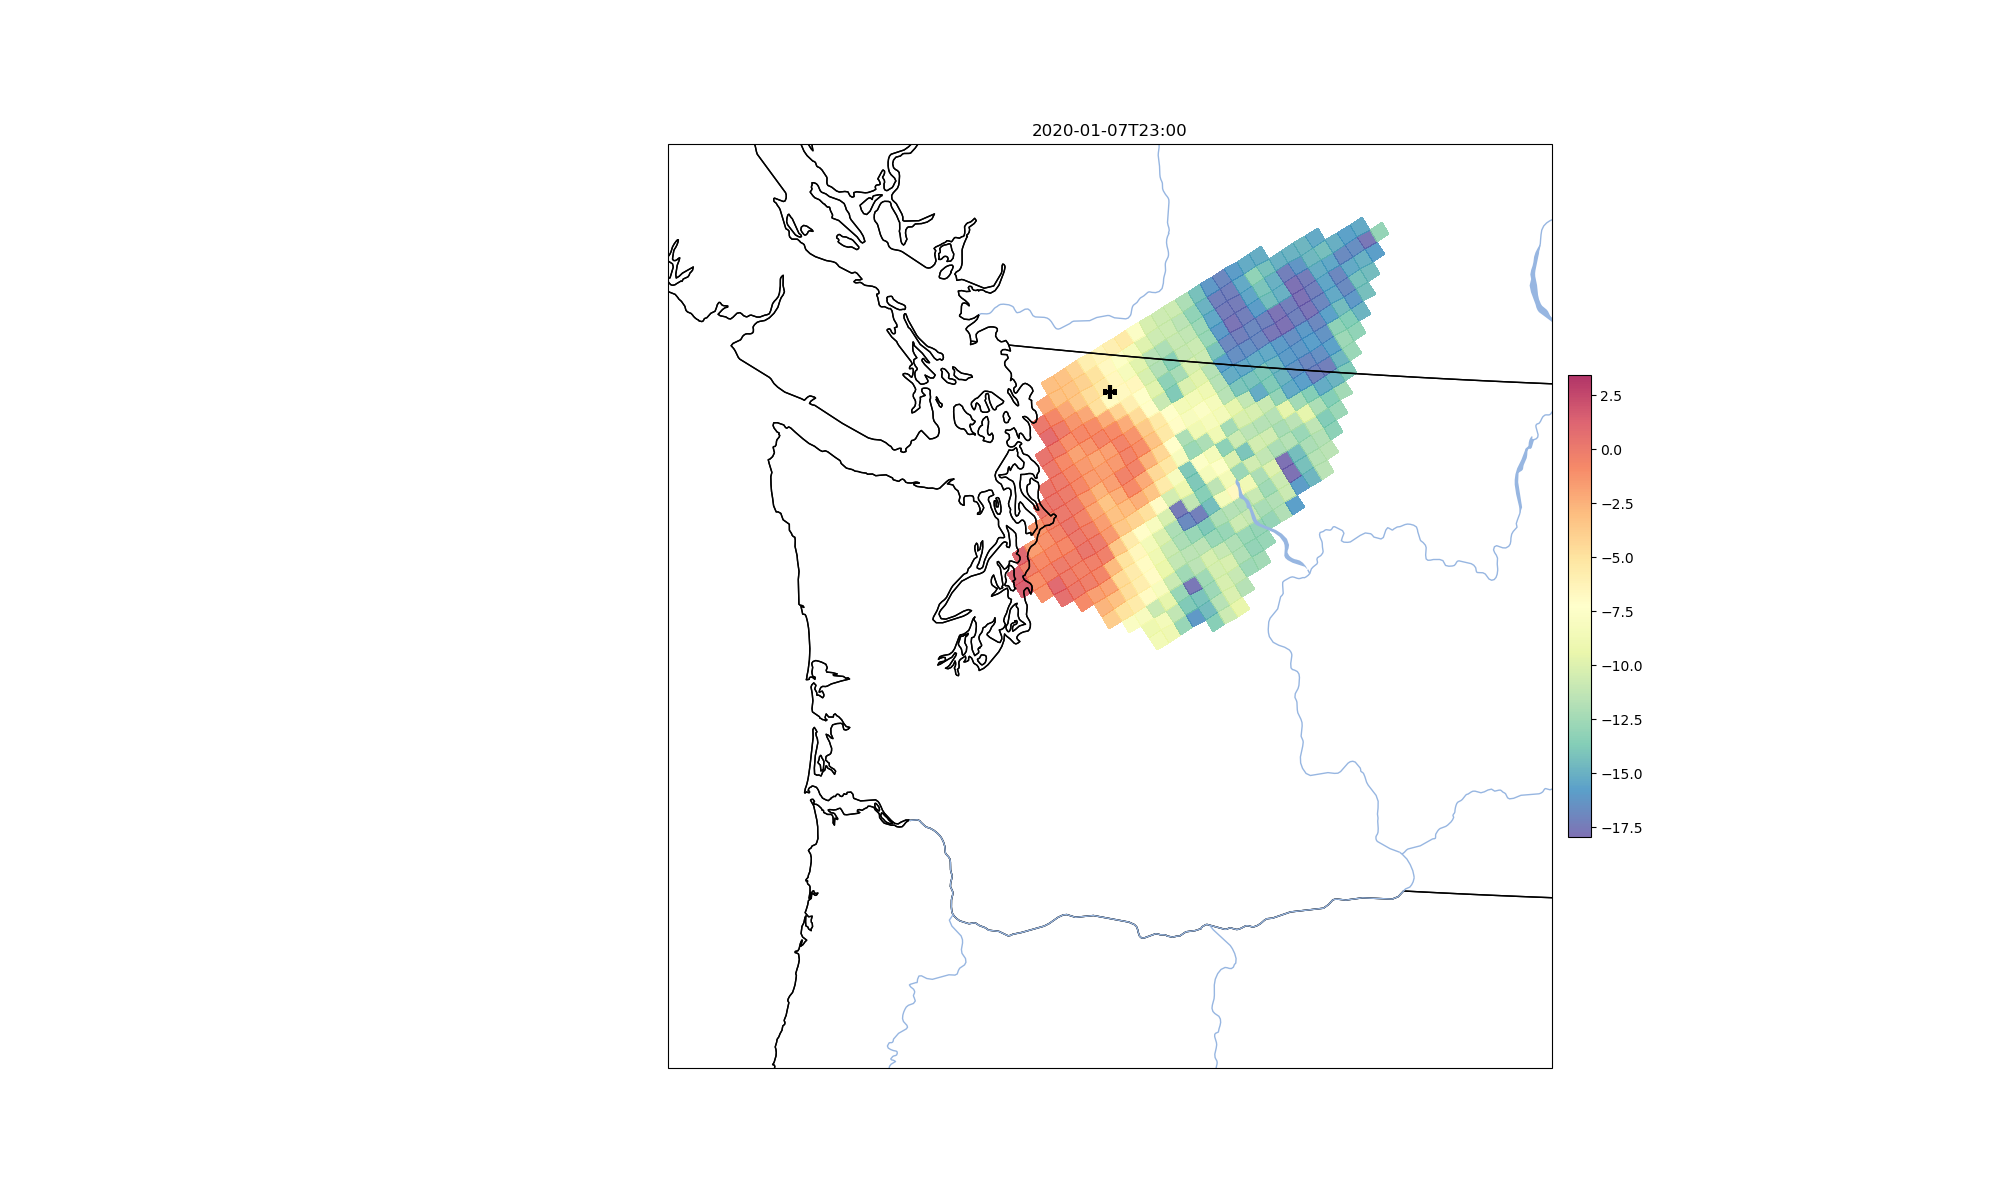

In [84]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import pyplot as plt
import matplotlib.animation as animation

mt_baker_lat_lon = (48.7758, -121.8199)
lats = masked_data_set.lat
lons = masked_data_set.lon

abslat = np.abs(lats-mt_baker_lat_lon[0])
abslon = np.abs(lons-mt_baker_lat_lon[1])

projection = ccrs.LambertConformal(central_longitude=cen_lon, 
                                   central_latitude=cen_lat, 
                                   standard_parallels=(sp1, sp2))

# Plot temp at a certain hour/to
fig = plt.figure(figsize=[20, 12])
ax = plt.axes(projection=projection)
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax.add_feature(cfeature.STATES.with_scale('10m'))
ax.add_feature(cfeature.RIVERS.with_scale('10m'))
ax.add_feature(cfeature.LAKES.with_scale('10m'))
ax.set_extent([-118, -125, 45, 50], crs=ccrs.PlateCarree())
mesh = ax.pcolormesh(lons, lats, masked_data_set.T2.sel(time='2020-01-01T00:00')-273.15, transform=ccrs.PlateCarree(), cmap='Spectral_r', alpha=.8)
fig.colorbar(mesh, ax=ax, shrink=.5, pad=.01)
mt_baker = ax.scatter(mt_baker_lat_lon[1], mt_baker_lat_lon[0], transform=ccrs.PlateCarree(), marker='+', s=100, c='k', linewidth=3)
plt.title('2020-01-01T00:00')

# Uncomment Below to create a gif of temeperature over time

# def update(frame):
#     mesh.set_array((masked_data_set.T2.sel(time=dts[frame])-273.15).values)
#     plt.title(dts[frame])

# ani = animation.FuncAnimation(fig, update, frames=168, interval=300)

# ani.save('animation.gif')

Text(0.5, 1.0, '2020-01-01T00:00')

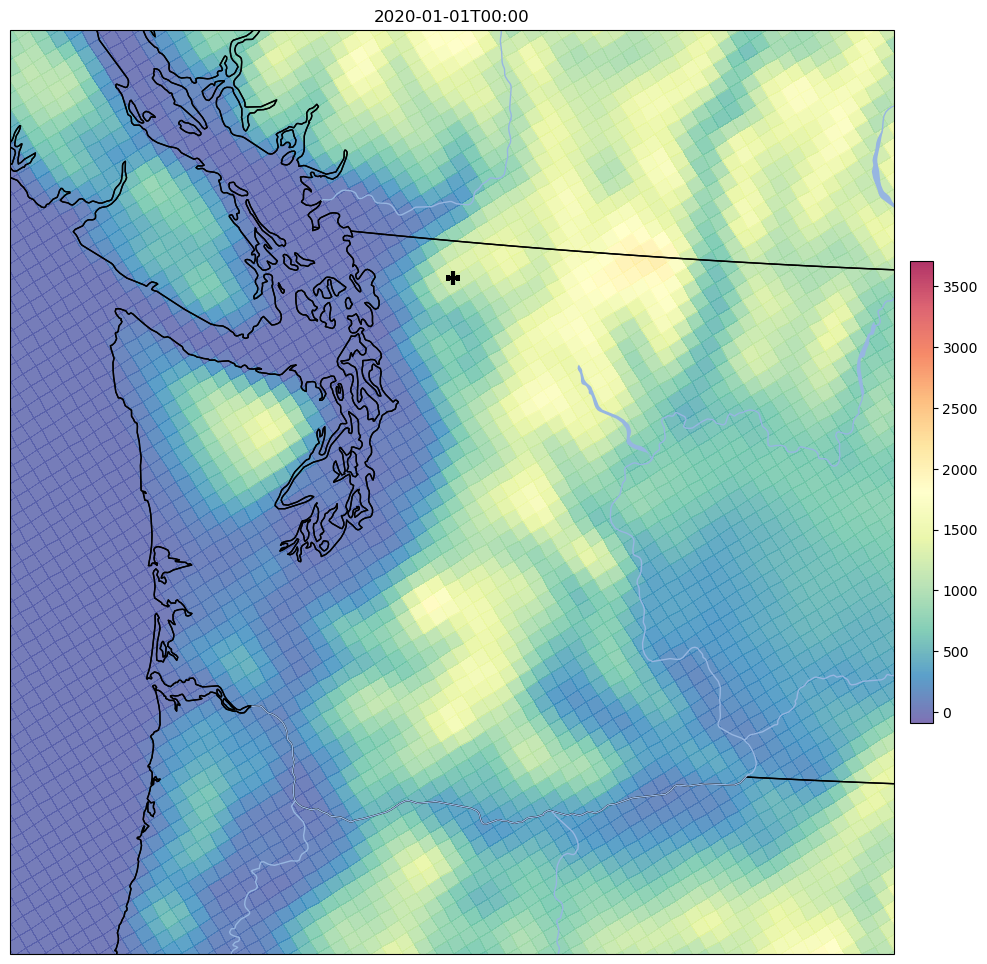

In [39]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import pyplot as plt
import matplotlib.animation as animation

mt_baker_lat_lon = (48.7758, -121.8199)
lats = x.lat
lons = x.lon

abslat = np.abs(lats-mt_baker_lat_lon[0])
abslon = np.abs(lons-mt_baker_lat_lon[1])

projection = ccrs.LambertConformal(central_longitude=cen_lon, 
                                   central_latitude=cen_lat, 
                                   standard_parallels=(sp1, sp2))

# Plot temp at a certain hour/to
fig = plt.figure(figsize=[20, 12])
ax = plt.axes(projection=projection)
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax.add_feature(cfeature.STATES.with_scale('10m'))
ax.add_feature(cfeature.RIVERS.with_scale('10m'))
ax.add_feature(cfeature.LAKES.with_scale('10m'))
ax.set_extent([-118, -125, 45, 50], crs=ccrs.PlateCarree())
mesh = ax.pcolormesh(lons, lats, x.hgt, transform=ccrs.PlateCarree(), cmap='Spectral_r', alpha=.8)
fig.colorbar(mesh, ax=ax, shrink=.5, pad=.01)
mt_baker = ax.scatter(mt_baker_lat_lon[1], mt_baker_lat_lon[0], transform=ccrs.PlateCarree(), marker='+', s=100, c='k', linewidth=3)
plt.title('2020-01-01T00:00')

### Write to Zarr

In [184]:
masked_data_set

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 168, y: 340, x: 270)
Coordinates:
    lat      (y, x) float32 367kB 22.27 22.31 22.35 22.4 ... 57.5 57.54 57.58
    lon      (y, x) float32 367kB -116.7 -116.6 -116.6 ... -111.2 -111.0 -110.9
  * time     (time) object 1kB '2020-01-01T00:00' ... '2020-01-07T23:00'
Dimensions without coordinates: y, x
Data variables: (12/21)
    Q2       (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    T2       (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    PSFC     (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    U10      (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    V10      (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    SNOW     (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    ...       ...
    LWUPB    (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    LWUPBC   (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    LWDNB    (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    LWDNBC   (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    RUNSF    (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
    RUNSB    (time, y, x) float32 62MB dask.array<chunksize=(1, 170, 135), meta=np.ndarray>
Attributes: (12/85)
    TITLE:                            OUTPUT FROM WRF V4.1.3 MODEL
    START_DATE:                      2019-12-19_00:00:00
    WEST-EAST_GRID_DIMENSION:        271
    SOUTH-NORTH_GRID_DIMENSION:      341
    BOTTOM-TOP_GRID_DIMENSION:       40
    DX:                              9000.0
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      0
    ETAC:                            0.0

In [185]:
masked_data_set.to_zarr('wrf.zarr')